## Data Loading: TensorFlow TFRecord
 This example demonstrates how to utilise rocAL to access data that has been saved in the TensorFlow TFRecord format.

## Common Code

In [1]:
from amd.rocal.plugin.tf import ROCALIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.types as types
import amd.rocal.fn as fn
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2023-08-21 01:55:39.215948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 01:55:39.327109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 01:55:39.329888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 01:55:40.737679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Configuring rocAL pipeline

Configure the pipeline parameters as required by the user.

In [2]:
image_path = os.path.join(os.environ['ROCAL_DATA_PATH'], "tf", "classification")
rocal_cpu = True
batch_size = 10
one_hot_label = 0
num_threads = 1
local_rank = 1
tf_record_reader_type = 0
featureKeyMap = {
    "image/encoded": "image/encoded",
    "image/class/label": "image/class/label",
    "image/filename": "image/filename",
}
path = "OUTPUT_IMAGES_PYTHON/TF_READER/CLASSIFICATION/"

## Defining and Running the Pipeline
 Creating the pipeline using tf.readers for reading the images stored in tf_record format. In this pipeline we add cascaded augmentations on the decoded images. We enable the output for different augmentations using set_outputs

In [3]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=local_rank, seed=2, rocal_cpu=rocal_cpu, tensor_layout = types.NCHW)


OK: loaded 114 kernels from libvx_rpp.so
Pipeline has been created succesfully


In [4]:
with pipe:
        inputs = fn.readers.tfrecord(path=image_path, reader_type=tf_record_reader_type, user_feature_key_map=featureKeyMap,
            features={
                "image/encoded": tf.io.FixedLenFeature((), tf.string, ""),
                "image/class/label": tf.io.FixedLenFeature([1], tf.int64, -1),
                "image/filename": tf.io.FixedLenFeature((), tf.string, "")
            }
        )
        jpegs = inputs["image/encoded"]
        images = fn.decoders.image(jpegs, user_feature_key_map=featureKeyMap, output_type=types.RGB, path=image_path)
        resized = fn.resize(images, resize_width=300, resize_height=300)
        if(one_hot_label == 1):
            labels = inputs["image/class/label"]
            _ = fn.one_hot(labels, num_classes=1000)
        pipe.set_outputs(resized)

Reading for image classification - file_name:: /media/MIVisionX-data/rocal_data/tf/classification/validation-00000-of-00128


In [5]:
pipe.build()
# Dataloader
imageIterator = ROCALIterator(pipe)

## Visualizing outputs
We have displayed the output of augmented images using imshow()

Load     time :: 89097
Decode   time :: 8056754
Process  time :: 601819
Transfer time :: 0


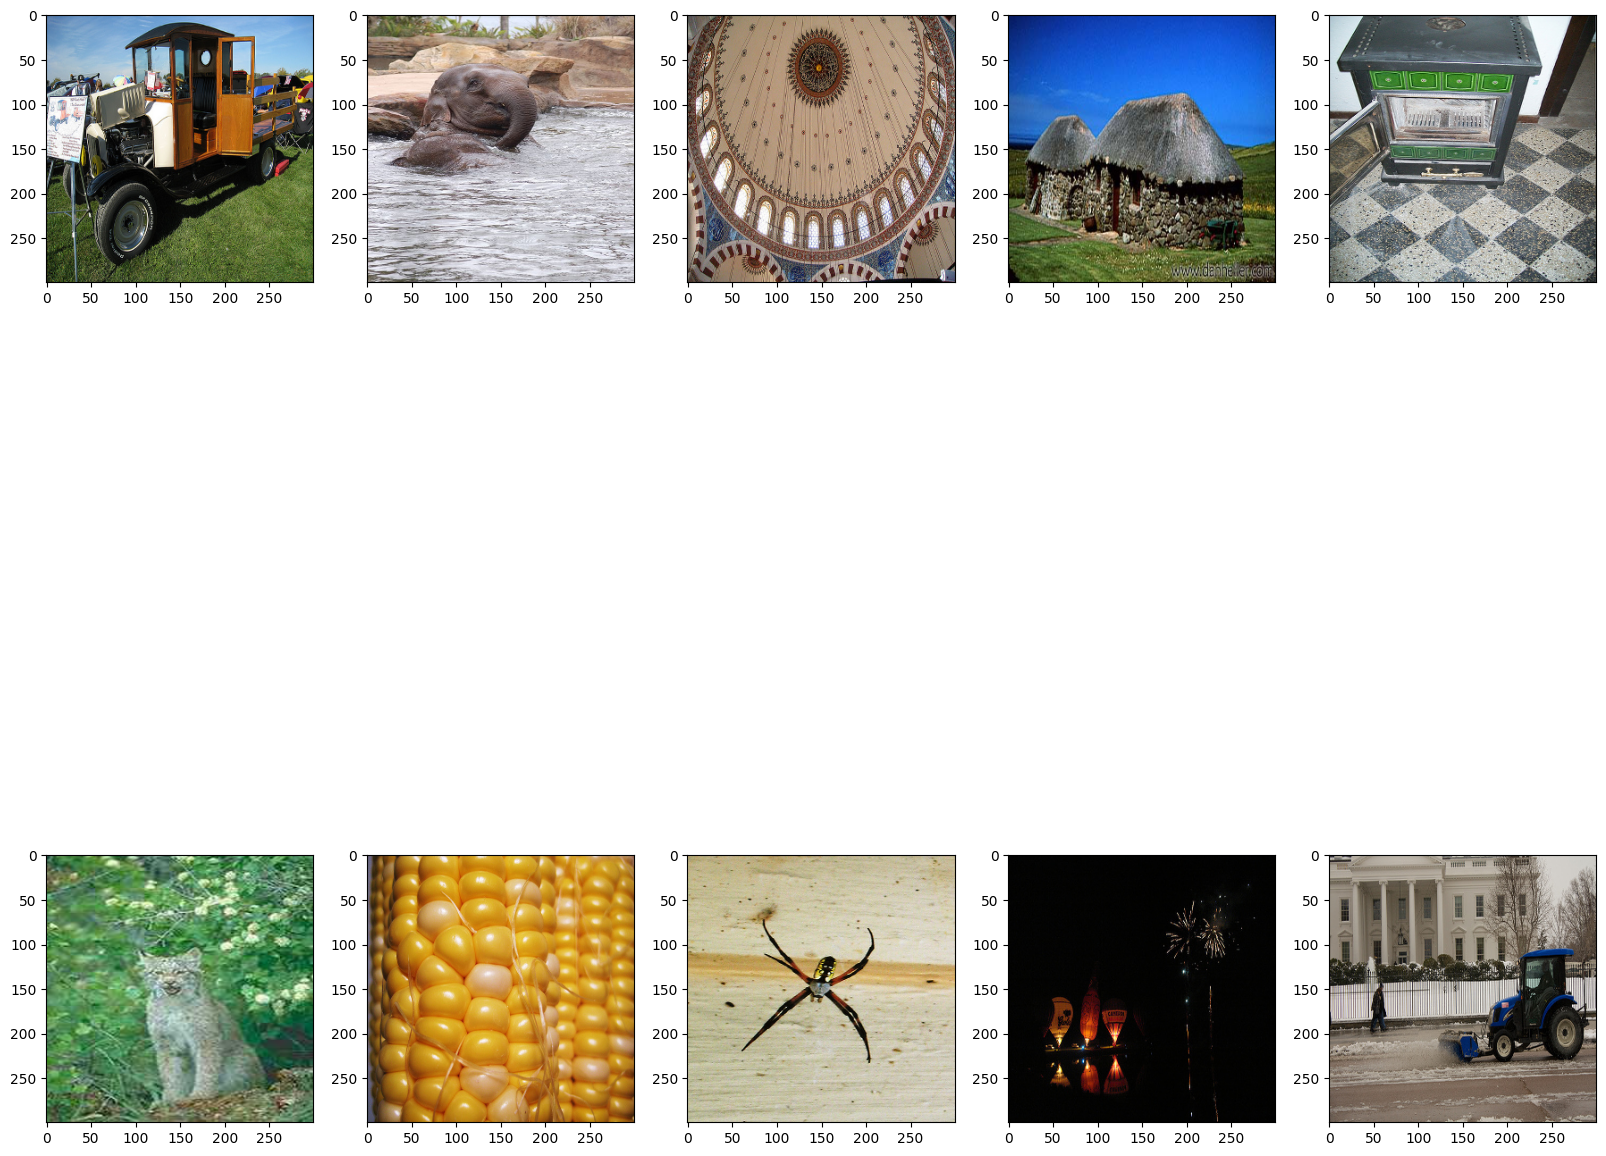

In [6]:
cnt = 0
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 20))
row = 0
col = 0
for i, ([images_array], labels_array) in enumerate(imageIterator, 0):
    for k in images_array:
        cnt = cnt + 1
        image = k.astype("int")
        axes[row, col].imshow(image)
        row = row + 1
        if row == 2:
            row = 0
            if col != 4:
                col = col + 1
imageIterator.reset()